In [ ]:
"""
v2:
dataset:
ignoring labels 1, 3, and 4, retaining only labels 0 (background noise) and label 2 (target class).
background noise (label 0) is downsampled to ensure it matches the number of samples with label 2
split the dataset using torch.utils.data.random_split, into 80% for the training set, 10% for the test set, and 10% for the validation set
model:
loss function modified to (MSE) loss
output: sums the spikes along time dimension
visualize the internal activity

v3:
split the dataset using random_split
Data Augmentation: for train_loader label 1
  time_shift: Shifts the event data along the time axis.
  add_noise: Adds Gaussian noise to event data.
  random_drop: Randomly drops parts of the event data.
add Weights and Biases to track training results

try differnt output: 
output = output.sum(dim=1) 
output = output.mean(dim=1) 
and synnet with different hidden layer

the best model is synnet with 32 hidden layer use augmented data,and mean around each time series. the accuracy rate is 80%

"""



'\ndataset: \nignoring labels 1, 3, and 4, retaining only labels 0 (background noise) and label 2 (target class). \nbackground noise (label 0) is downsampled to ensure it matches the number of samples with label 2 \nsplit the dataset using torch.utils.data.random_split, into 80% for the training set, 10% for the test set, and 10% for the validation set\nmodel:\nloss function modified to (MSE) loss \noutput: sums the spikes along time dimension \nvisualize the internal activity \n'

In [9]:
import torch
import numpy as np

# Load tensor
labels_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/labels_tensor.pt")
spikes_tensor = torch.load("/Users/xiaoyuliu/Documents/school/capstone/tensors/spike_data_tensor.pt")

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')


Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


/var/folders/kd/vt_v73sx4y5b36zjny3pbn380000gn/T/ipykernel_99291/4283774041.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_tensor = torch.load("/Users/xiaoyuliu/

# dataset

In [10]:
import torch
import numpy as np

class CCMKDataset(torch.utils.data.Dataset):
    def __init__(self, spikes_tensor, labels_tensor, target_label=2):
        self.spikes_tensor = spikes_tensor
        self.labels_tensor = labels_tensor
        self.target_label = target_label

        # Step 1: Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]

        # Convert the target label (2) to 1 (positive sample)
        self.labels_tensor[self.labels_tensor == target_label] = 1

        # Step 2: Downsample label 0 (background noise) to match the number of target samples (label 2 -> now 1)
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]

        # print samples
        #print(f"Number of label 0 samples before downsampling: {len(label_0_indices)}")
        #print(f"Number of label 1 samples (after converting target label 2 to 1): {len(label_1_indices)}")

        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False))
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False))

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # print data after samples
        print(f"Number of downsampled label 0 samples: {len(selected_label_0_indices)}")
        print(f"Number of target label 1 samples: {len(selected_label_1_indices)}")
        print(f"Balanced dataset length: {len(balanced_indices)}")

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        return self.spikes_tensor[idx], self.labels_tensor[idx]

dataset = CCMKDataset(spikes_tensor=spikes_tensor, labels_tensor=labels_tensor)


Number of downsampled label 0 samples: 1046
Number of target label 1 samples: 1046
Balanced dataset length: 2092
Filtered Labels distribution after processing: tensor([1046, 1046])


# split and dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split


# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
# Print the shape of the first sample in the dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check batch information in the train_loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Calculate and print the labels distribution in each loader

# Training data label distribution
train_labels = torch.cat([batch[1] for batch in train_loader])
print(f'Train Labels distribution: {torch.bincount(train_labels.int())}')

# Validation data label distribution
val_labels = torch.cat([batch[1] for batch in val_loader])
print(f'Validation Labels distribution: {torch.bincount(val_labels.int())}')

# Test data label distribution
test_labels = torch.cat([batch[1] for batch in test_loader])
print(f'Test Labels distribution: {torch.bincount(test_labels.int())}')


Train dataset size: 1672
Test dataset size: 212
Validation dataset size: 208
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Train Labels distribution: tensor([836, 836])
Validation Labels distribution: tensor([104, 104])
Test Labels distribution: tensor([106, 106])


# model

In [13]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet

# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model
net = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use
    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (2 for binary classification)
    size_hidden_layers=[24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)
print(net)




SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


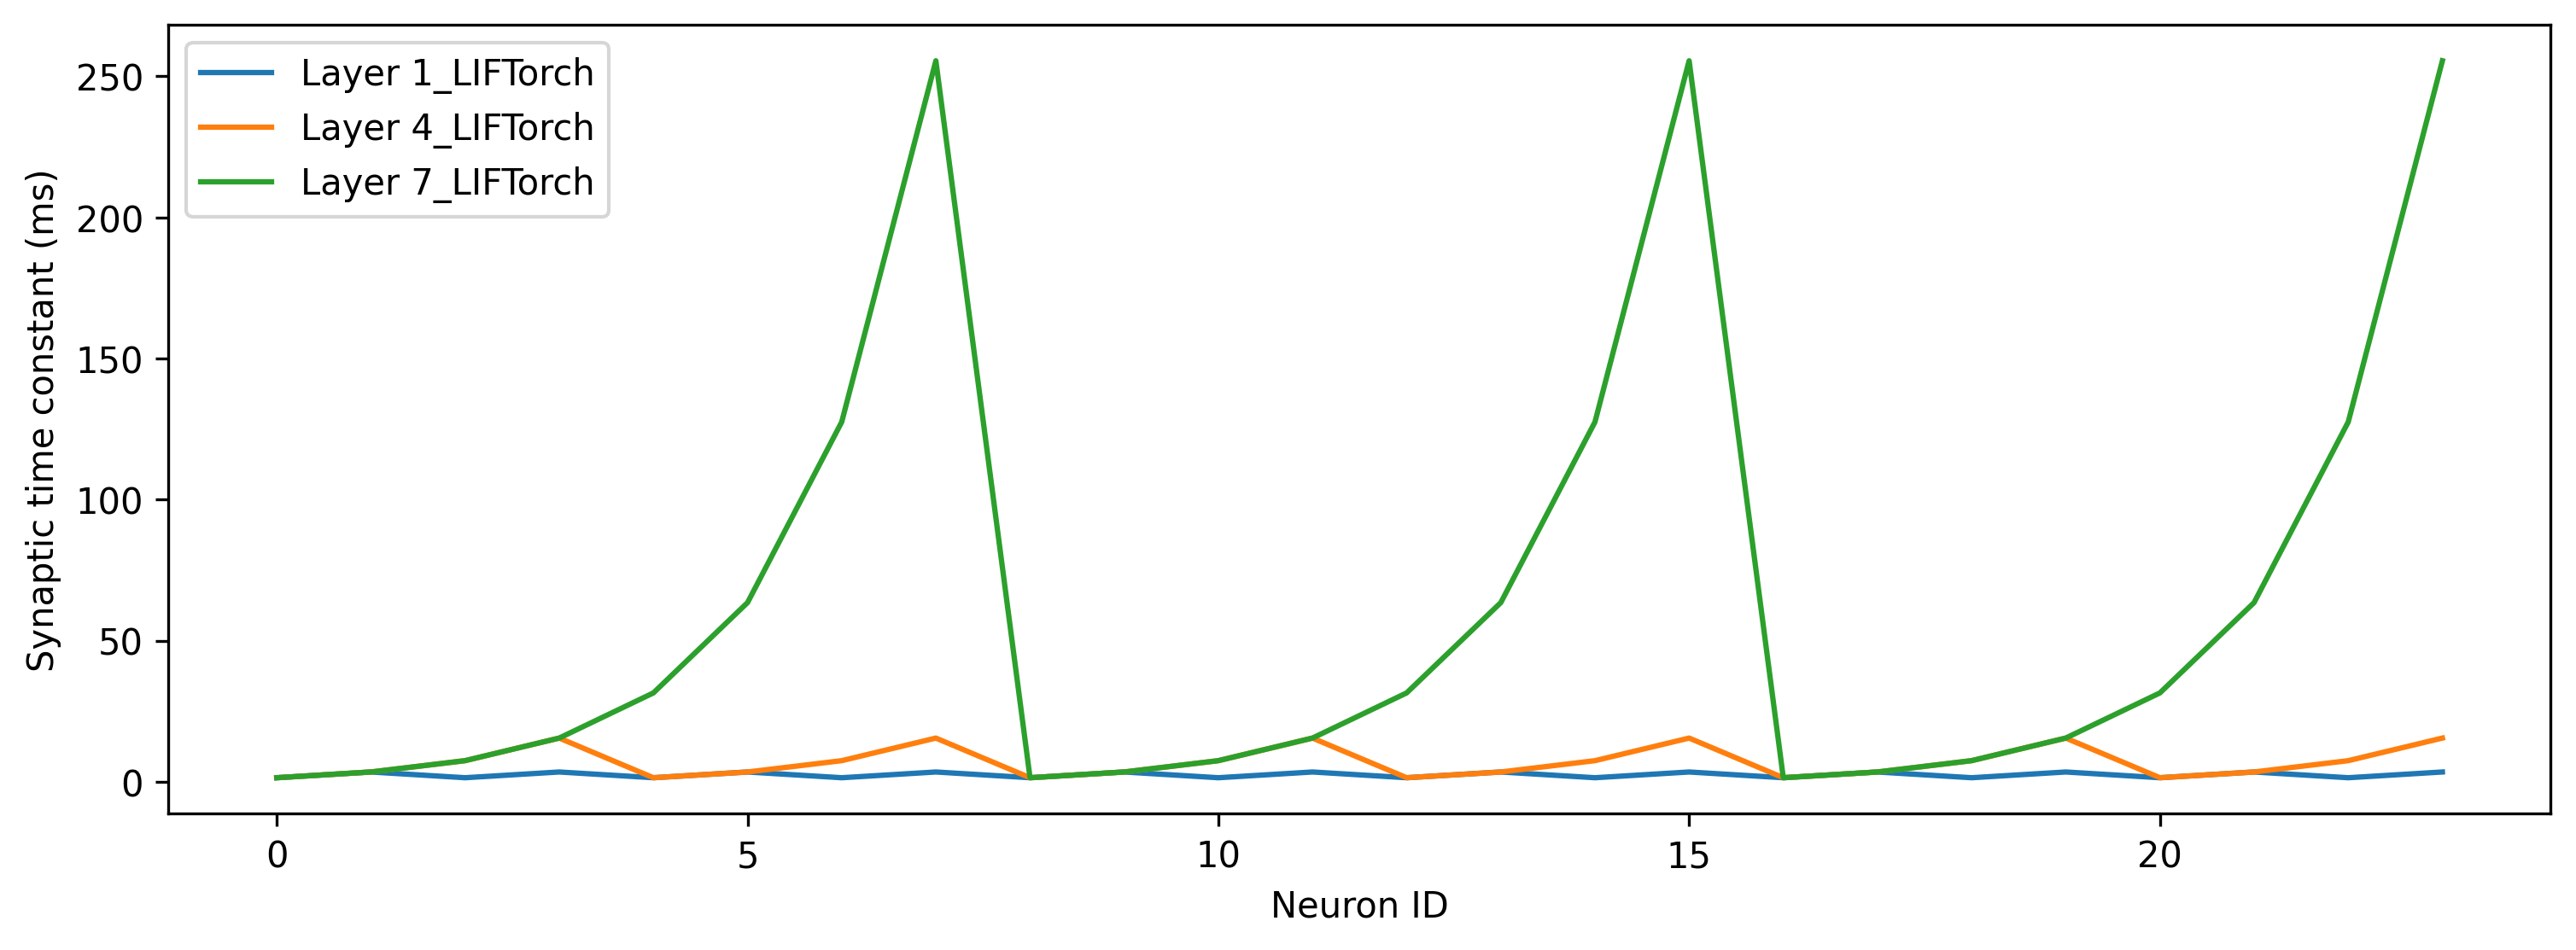

In [7]:

# - Import the matplotlib plotting library
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Plot the synaptic time constants for each layer
for lyr in net.lif_names[:-1]:
    plt.plot(net.seq[lyr].tau_syn / 1e-3, label = f"Layer {lyr}")

plt.xlabel('Neuron ID')
plt.ylabel('Synaptic time constant (ms)')
plt.legend();

# Training loop

In [25]:

from tqdm import trange

# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)  # Use Adam optimizer with a learning rate of 1e-3
loss_fun = MSELoss()  # Using MSE Loss as the loss function, targets are of float type
n_epochs = 20  # Set the number of training epochs

# Create a list to store the loss for each epoch

train_losses = []
val_losses = []

# Training and Validation loop
for epoch in trange(n_epochs):  # Progress bar for epochs
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_losses.append(val_loss / len(val_loader))

    # Print training and validation losses for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

# End of training
print('Training completed')


  5%|▌         | 1/20 [00:09<03:08,  9.94s/it]

Epoch 1/20, Training Loss: 0.1557585190770761, Validation Loss: 0.16719124146870204


 10%|█         | 2/20 [00:19<02:51,  9.55s/it]

Epoch 2/20, Training Loss: 0.1482561334686459, Validation Loss: 0.14036614341395243


 15%|█▌        | 3/20 [00:28<02:42,  9.57s/it]

Epoch 3/20, Training Loss: 0.15562320894227838, Validation Loss: 0.1468172754560198


 20%|██        | 4/20 [00:38<02:32,  9.51s/it]

Epoch 4/20, Training Loss: 0.15160191326208836, Validation Loss: 0.14798838006598608


 25%|██▌       | 5/20 [00:47<02:21,  9.41s/it]

Epoch 5/20, Training Loss: 0.15534744228956834, Validation Loss: 0.1518268489411899


 30%|███       | 6/20 [00:57<02:12,  9.48s/it]

Epoch 6/20, Training Loss: 0.15259203785714112, Validation Loss: 0.14763783024890081


 35%|███▌      | 7/20 [01:05<02:00,  9.29s/it]

Epoch 7/20, Training Loss: 0.14687840190698515, Validation Loss: 0.1385468989610672


 40%|████      | 8/20 [01:14<01:49,  9.13s/it]

Epoch 8/20, Training Loss: 0.15872969548657256, Validation Loss: 0.1834961058838027


 45%|████▌     | 9/20 [01:23<01:40,  9.15s/it]

Epoch 9/20, Training Loss: 0.14620774407994072, Validation Loss: 0.13025289667504175


 50%|█████     | 10/20 [01:33<01:32,  9.27s/it]

Epoch 10/20, Training Loss: 0.1509381912226947, Validation Loss: 0.1541611828974315


 55%|█████▌    | 11/20 [01:42<01:23,  9.23s/it]

Epoch 11/20, Training Loss: 0.15113078296746849, Validation Loss: 0.13923792008842742


 60%|██████    | 12/20 [01:51<01:12,  9.09s/it]

Epoch 12/20, Training Loss: 0.15874744220724646, Validation Loss: 0.15257213371140615


 65%|██████▌   | 13/20 [02:01<01:05,  9.33s/it]

Epoch 13/20, Training Loss: 0.14881130856163097, Validation Loss: 0.15201021518026078


 70%|███████   | 14/20 [02:11<00:56,  9.45s/it]

Epoch 14/20, Training Loss: 0.1454398045843502, Validation Loss: 0.1436812031481947


 75%|███████▌  | 15/20 [02:22<00:50, 10.11s/it]

Epoch 15/20, Training Loss: 0.15036764389501428, Validation Loss: 0.1539782445345606


 80%|████████  | 16/20 [02:34<00:42, 10.58s/it]

Epoch 16/20, Training Loss: 0.15008869851535223, Validation Loss: 0.13899109619004385


 85%|████████▌ | 17/20 [02:44<00:31, 10.46s/it]

Epoch 17/20, Training Loss: 0.14791840680365292, Validation Loss: 0.13758060655423573


 90%|█████████ | 18/20 [02:53<00:20, 10.08s/it]

Epoch 18/20, Training Loss: 0.150636706430957, Validation Loss: 0.1374913283756801


 95%|█████████▌| 19/20 [03:04<00:10, 10.17s/it]

Epoch 19/20, Training Loss: 0.1438074066953839, Validation Loss: 0.15198526850768498


100%|██████████| 20/20 [03:14<00:00,  9.70s/it]

Epoch 20/20, Training Loss: 0.15243135195858074, Validation Loss: 0.1338441041963441
Training completed


# Loss Curve Plot

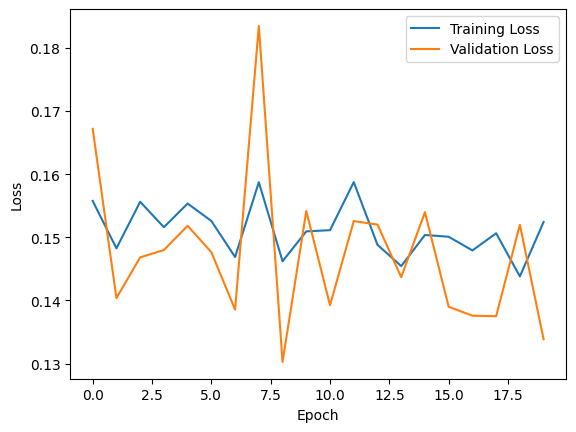

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix

# Define a function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)  # Forward pass through the model

            # If summing over time steps is used to get the final output:
            outputs = outputs.mean(dim=1)  # mean spikes over the time dimension

            # Use Sigmoid activation to normalize output between 0 and 1 (for binary classification)
            predictions = torch.round(torch.sigmoid(outputs))

            # Compare predictions with ground truth targets
            correct += (predictions == targets.unsqueeze(1)).sum().item()  # Accumulate correct predictions
            total += targets.size(0)  # Total number of samples

            # Save all targets and predictions for confusion matrix
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = correct / total  # Calculate accuracy
    return accuracy, all_targets, all_predictions

# Using the validation or test data loader
accuracy, all_targets, all_predictions = calculate_accuracy(net, test_loader)

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 69.34%


# train with Weights and Biases (W&B) 

In [7]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
from rockpool.nn.networks import SynNet
from tqdm import trange


In [38]:
# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

In [50]:
import torch
from sklearn.metrics import accuracy_score
import wandb
# Initialize a new W&B run
wandb.login(key="2ac9bb7cd9b60300ecd28184faa02b29add8e82b")
#wandb.init(project="SNN_meerkat", name="run_with_new_lr")

wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="outputs.mean(dim=1),learning_rate=1e-3")
# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/xiaoyuliu/.netrc


In [51]:
# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(net, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(net, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net.state_dict(), "model_mean.pth")
wandb.save("model_mean.pth")

# Finish the W&B run
wandb.finish()


Epoch 1/10, Training Loss: 0.1653227058221709, Validation Loss: 0.17155092741761888, Validation Accuracy: 71.63%
Epoch 2/10, Training Loss: 0.16347199411324734, Validation Loss: 0.16534180247357913, Validation Accuracy: 82.69%
Epoch 3/10, Training Loss: 0.15784211049102387, Validation Loss: 0.13914733486516134, Validation Accuracy: 71.15%
Epoch 4/10, Training Loss: 0.15940422466341056, Validation Loss: 0.14992621115275792, Validation Accuracy: 72.12%
Epoch 5/10, Training Loss: 0.1500370832827856, Validation Loss: 0.1560626881463187, Validation Accuracy: 67.31%
Epoch 6/10, Training Loss: 0.15300051136961523, Validation Loss: 0.1496483130114419, Validation Accuracy: 82.21%
Epoch 7/10, Training Loss: 0.153404305284878, Validation Loss: 0.15588063161287988, Validation Accuracy: 82.69%
Epoch 8/10, Training Loss: 0.15095414404036864, Validation Loss: 0.17053867982966558, Validation Accuracy: 81.73%
Epoch 9/10, Training Loss: 0.14264052853269396, Validation Loss: 0.1644481590815953, Validatio

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▇▆▆▃▄▄▄▁▃
val_accuracy,▃█▃▃▁███▃▃
val_loss,█▇▁▃▅▃▅█▆▂
epoch,10
test_accuracy,0.72642
train_loss,0.14916
val_accuracy,0.71635
val_loss,0.14169


In [52]:
# outputs.sum(dim=1)
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="outputs.sum(dim=1),learning_rate=1e-3")
# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

# Function to calculate accuracy
def calculate_accuracy_sum(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.sum(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy
# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.sum(dim=1)  # sum spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net(inputs)
            output = output.sum(dim=1)  # sum spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy_sum(net, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy_sum(net, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net.state_dict(), "model_sum.pth")
wandb.save("model_sum.pth")

# Finish the W&B run
wandb.finish()


Epoch 1/10, Training Loss: 760.1167452830189, Validation Loss: 290.2767857142857, Validation Accuracy: 85.10%
Epoch 2/10, Training Loss: 149.82724056603774, Validation Loss: 97.97321428571429, Validation Accuracy: 79.81%
Epoch 3/10, Training Loss: 40.70518867924528, Validation Loss: 25.977678571428573, Validation Accuracy: 67.79%
Epoch 4/10, Training Loss: 7.476415094339623, Validation Loss: 7.325892857142857, Validation Accuracy: 56.25%
Epoch 5/10, Training Loss: 2.2258254716981134, Validation Loss: 5.102678571428571, Validation Accuracy: 53.37%
Epoch 6/10, Training Loss: 1.5047169811320755, Validation Loss: 2.5580357142857144, Validation Accuracy: 51.92%
Epoch 7/10, Training Loss: 0.8307783018867925, Validation Loss: 1.1160714285714286, Validation Accuracy: 50.00%
Epoch 8/10, Training Loss: 0.6173349056603774, Validation Loss: 0.8214285714285714, Validation Accuracy: 50.00%
Epoch 9/10, Training Loss: 0.5819575471698113, Validation Loss: 0.6919642857142857, Validation Accuracy: 50.48%

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,█▇▅▂▂▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.50943
train_loss,0.55189
val_accuracy,0.50481
val_loss,0.69196


training and validation loss are similar through epochs, and validation accuracy drops and fluctuates
test accuracy is higher than validation accuracy

In [ ]:
# Data augmentation


In [53]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# Data augmentation functions

# Time shift function：Shifts the event data along the time axis.
def time_shift(event_data, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)  # Randomly choose a shift amount
    return np.roll(event_data, shift, axis=0)  # Apply shift along the time axis

# Add noise function：Adds Gaussian noise to event data.
def add_noise(event_data, noise_factor=0.01):
    noise = np.random.normal(0, noise_factor, event_data.shape)  # Generate Gaussian noise
    return event_data + noise  # Add noise to the data

# Random drop function：Randomly drops parts of the event data.
def random_drop(event_data, drop_rate=0.1):
    mask = np.random.binomial(1, 1 - drop_rate, event_data.shape)  # Generate a mask to randomly drop parts of the data
    return event_data * mask  # Apply the mask to the data

# Combine augmentation functions
def augment_data(event_data, augmentation_funcs):
    for func in augmentation_funcs:
        event_data = func(event_data)  # Apply each augmentation function in sequence
    return event_data



# Data loader with augmentation applied to label 1 (event call) samples
def augment_train_data(train_loader):
    augmentation_funcs = [time_shift, add_noise, random_drop]  # List of augmentation functions to apply

    for batch_idx, (data, labels) in enumerate(train_loader):
        for i in range(data.shape[0]):  # Iterate over each sample in the batch
            if labels[i] == 1:  # Only augment data with label 1 (event call)
                # Apply augmentations and convert back to torch.Tensor
                augmented_data = augment_data(data[i].numpy(), augmentation_funcs)  # Apply augmentations
                data[i] = torch.from_numpy(augmented_data).to(data[i].device)  # Ensure the tensor is on the same device (CPU or GPU)
        yield data, labels  # Yield augmented data and labels for training



In [45]:
train_loader_augmented=augment_train_data(train_loader)
train_labels_augmented = torch.cat([batch[1] for batch in train_loader_augmented])
print(f'Train Labels distribution: {torch.bincount(train_labels_augmented.int())}')

Train Labels distribution: tensor([836, 836])


In [54]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="augmented data,outputs.mean,learning_rate=1e-3")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader): # Use augmented data

        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(net, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(net, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net.state_dict(), "model_augmented.pth")
wandb.save("model_augmented.pth")

# Finish the W&B run
wandb.finish()







Epoch 1/10, Training Loss: 0.4913842616216192, Validation Loss: 0.4837008224089264, Validation Accuracy: 69.23%
Epoch 2/10, Training Loss: 0.19448882791231265, Validation Loss: 0.1568618044257164, Validation Accuracy: 72.12%
Epoch 3/10, Training Loss: 0.12692724027723637, Validation Loss: 0.21648787866745675, Validation Accuracy: 74.04%
Epoch 4/10, Training Loss: 0.12457389539142824, Validation Loss: 0.22916695848107338, Validation Accuracy: 84.62%
Epoch 5/10, Training Loss: 0.11334106459651354, Validation Loss: 0.19446578568645886, Validation Accuracy: 68.75%
Epoch 6/10, Training Loss: 0.11239857184437085, Validation Loss: 0.21634126667465484, Validation Accuracy: 69.71%
Epoch 7/10, Training Loss: 0.10239671803307983, Validation Loss: 0.27744829441819874, Validation Accuracy: 72.60%
Epoch 8/10, Training Loss: 0.09736697990798725, Validation Loss: 0.2323922993881362, Validation Accuracy: 61.54%
Epoch 9/10, Training Loss: 0.09009550677014971, Validation Loss: 0.256587684952787, Validati

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▃▄▅█▃▃▄▁▃▃
val_loss,█▁▂▃▂▂▄▃▃▃
epoch,10
test_accuracy,0.75
train_loss,0.10532
val_accuracy,0.66827
val_loss,0.24032


# synnet with more hidden layer

In [56]:
# Define dataset characteristics
n_channels = 16  # Number of input channels
n_classes = 1    # the output of MSELoss is discrite
n_time = 101     # Number of time steps
batch_size = 32  # Batch size

# Initialize the SynNet model
net_32 = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use
    n_channels=n_channels,                # Number of input channels
    n_classes=n_classes,                  # Number of output classes (2 for binary classification)
    size_hidden_layers=[32, 32, 32],      # Number of neurons in each hidden layer
    time_constants_per_layer=[2, 4, 8],   # Time constants for each layer
)
print(net_32)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 32)
        LIFTorch '1_LIFTorch' with shape (32, 32)
        TimeStepDropout '2_TimeStepDropout' with shape (32,)
        LinearTorch '3_LinearTorch' with shape (32, 32)
        LIFTorch '4_LIFTorch' with shape (32, 32)
        TimeStepDropout '5_TimeStepDropout' with shape (32,)
        LinearTorch '6_LinearTorch' with shape (32, 32)
        LIFTorch '7_LIFTorch' with shape (32, 32)
        TimeStepDropout '8_TimeStepDropout' with shape (32,)
        LinearTorch '9_LinearTorch' with shape (32, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


In [57]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="32layer,outputs.mean,learning_rate=1e-3")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net_32.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net_32.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in train_loader: # Use augmented data

        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net_32(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net_32.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net_32(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(net_32, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(net_32, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net_32.state_dict(), "model_32layer.pth")
wandb.save("model_32layer.pth")

# Finish the W&B run
wandb.finish()







Epoch 1/10, Training Loss: 0.42079283128369527, Validation Loss: 0.2697376566273825, Validation Accuracy: 50.96%
Epoch 2/10, Training Loss: 0.22867982975154552, Validation Loss: 0.1687925388770444, Validation Accuracy: 61.06%
Epoch 3/10, Training Loss: 0.182396041194223, Validation Loss: 0.1818794927426747, Validation Accuracy: 62.98%
Epoch 4/10, Training Loss: 0.16924123381668665, Validation Loss: 0.1606433806674821, Validation Accuracy: 60.10%
Epoch 5/10, Training Loss: 0.16453985659019002, Validation Loss: 0.1351281138403075, Validation Accuracy: 62.02%
Epoch 6/10, Training Loss: 0.15683511082293852, Validation Loss: 0.15400975570082664, Validation Accuracy: 62.50%
Epoch 7/10, Training Loss: 0.15670026360817677, Validation Loss: 0.14597657855067933, Validation Accuracy: 65.38%
Epoch 8/10, Training Loss: 0.1594391960018086, Validation Loss: 0.15101241639682225, Validation Accuracy: 60.58%
Epoch 9/10, Training Loss: 0.1554591141219409, Validation Loss: 0.13859897745507105, Validation 

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▆▇▅▆▆█▆█▇
val_loss,█▃▃▂▁▂▂▂▁▂
epoch,10
test_accuracy,0.68396
train_loss,0.15842
val_accuracy,0.64423
val_loss,0.15294


In [59]:
wandb.init(project="SNN_meerkat", config={
    "learning_rate": 1e-3,
    "epochs": 10,
    "batch_size": 32,
},name="32layer, augmented_data, outputs.mean,learning_rate=1e-3")

# Access hyperparameters
learning_rate = wandb.config.learning_rate
n_epochs = wandb.config.epochs
batch_size = wandb.config.batch_size


# Define the loss function and optimizer
optimizer = Adam(net_32.parameters().astorch(), lr=1e-3)
loss_fun = MSELoss()
n_epochs = 10

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for inputs, targets in data_loader:
            inputs = inputs.transpose(1, 2)  # Ensure input shape matches model requirements
            outputs, _, _ = model(inputs)
            outputs = outputs.mean(dim=1)

            predictions = torch.round(torch.sigmoid(outputs))  # For binary classification
            correct += (predictions == targets.unsqueeze(1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    return accuracy

# Training and Validation loop
for epoch in range(n_epochs):  # Progress bar for epochs
    net_32.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize running loss for training

    # Training phase
    for inputs, targets in augment_train_data(train_loader): # Use augmented data

        optimizer.zero_grad()  # Clear gradients

        # Adjust input dimensions to match model expectations
        inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

        # Forward pass through the network
        output, _, _ = net_32(inputs)  # Output shape [batch_size, n_time, n_classes]
        output = output.mean(dim=1)  # mean spikes over the time dimension [batch_size, n_classes]

        # Ensure targets are of float type as required by MSELoss
        targets = targets.float().unsqueeze(1)  # Reshape targets to [batch_size, 1]

        # Compute the loss
        loss = loss_fun(output, targets)

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Accumulate loss for this batch
        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    net_32.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize running loss for validation
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # Adjust input dimensions to match model expectations
            inputs = inputs.transpose(1, 2)  # [batch_size, n_time, n_channels]

            # Forward pass through the network
            output, _, _ = net_32(inputs)
            output = output.mean(dim=1)  # mean spikes over the time dimension

            # Ensure targets are of float type
            targets = targets.float().unsqueeze(1)

            # Compute validation loss
            loss = loss_fun(output, targets)

            # Accumulate validation loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(net_32, val_loader)

    # Log training loss, validation loss, and accuracy to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy  # Log accuracy
    })

    # Print training and validation losses, and validation accuracy for the current epoch
    print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# End of training
print('Training completed')



# Final evaluation on test data (to evaluate generalization after training)
test_accuracy = calculate_accuracy(net_32, test_loader)

# Log test accuracy to W&B
wandb.log({"test_accuracy": test_accuracy})

# Print the final test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Optionally save the model using W&B
torch.save(net_32.state_dict(), "model_32layer_augmented.pth")
wandb.save("model_32layer_augmented.pth")

# Finish the W&B run
wandb.finish()



Epoch 1/10, Training Loss: 0.2213059365749359, Validation Loss: 0.1532522173864501, Validation Accuracy: 61.54%
Epoch 2/10, Training Loss: 0.15318813371770787, Validation Loss: 0.17787078022956848, Validation Accuracy: 69.71%
Epoch 3/10, Training Loss: 0.13010383931533345, Validation Loss: 0.20635932896818435, Validation Accuracy: 72.60%
Epoch 4/10, Training Loss: 0.12081131627256016, Validation Loss: 0.2315936285470213, Validation Accuracy: 70.19%
Epoch 5/10, Training Loss: 0.11947404206642565, Validation Loss: 0.2381734305194446, Validation Accuracy: 69.23%
Epoch 6/10, Training Loss: 0.11295692510199996, Validation Loss: 0.24698603126619542, Validation Accuracy: 72.12%
Epoch 7/10, Training Loss: 0.10187934563969667, Validation Loss: 0.24181102961301804, Validation Accuracy: 72.60%
Epoch 8/10, Training Loss: 0.10372613040062617, Validation Loss: 0.26845232849674566, Validation Accuracy: 73.08%
Epoch 9/10, Training Loss: 0.10059525086632315, Validation Loss: 0.26810265864644733, Valida

epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▄▃▄▅▅▆█
val_loss,▁▂▄▅▆▆▆███
epoch,10
test_accuracy,0.80189
train_loss,0.09751
val_accuracy,0.83654
val_loss,0.27574


# Visualize Single Intermediate Activations

Activation from 0_LinearTorch:  torch.Size([1, 101, 24])
Activation from 1_LIFTorch:  torch.Size([1, 101, 24])
Activation from 3_LinearTorch:  torch.Size([1, 101, 24])


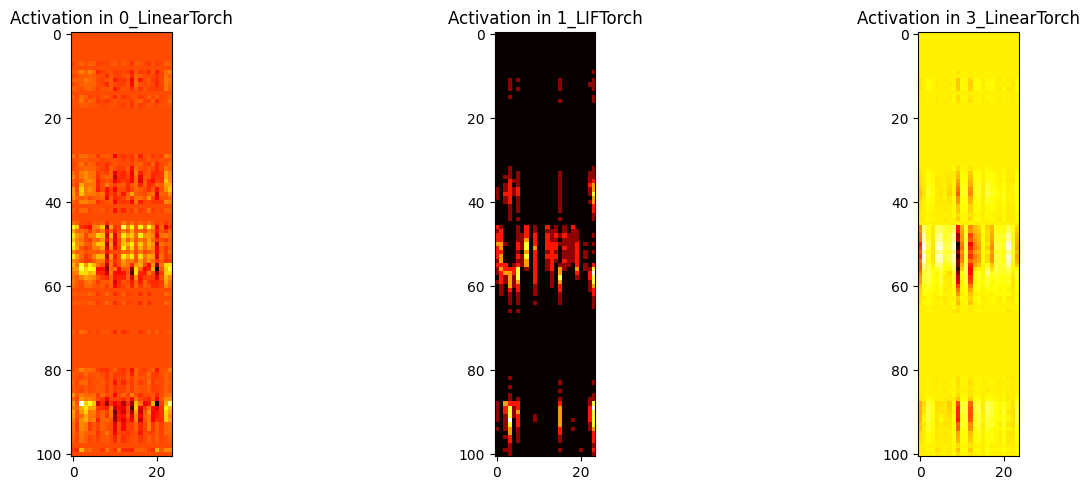

In [58]:
# Testing a single sample to visualize intermediate activations

# Dictionary to store activations
activations = {}

# Define a hook to capture the output of a specific layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()  # Save the output without gradients
    return hook

# Register the hook to layers inside 'seq'
net.seq[0].register_forward_hook(get_activation('0_LinearTorch'))  # First Linear layer
net.seq[1].register_forward_hook(get_activation('1_LIFTorch'))  # First LIF layer
net.seq[3].register_forward_hook(get_activation('3_LinearTorch'))  # Second Linear layer

# Testing a single sample
inputs, target = next(iter(train_loader))  # Get a batch of data
single_input = inputs[0].unsqueeze(0)  # Select a single sample and add batch dimension

# Adjust the single input's dimensions (transpose) before forwarding through the network
single_input = single_input.transpose(1, 2)  # Ensure input has shape [batch_size, n_time, n_channels]

# Forward pass
net(single_input)

# Visualize the activation of a specific layer
# Print activation shapes for each registered layer
print("Activation from 0_LinearTorch: ", activations['0_LinearTorch'].shape)
print("Activation from 1_LIFTorch: ", activations['1_LIFTorch'].shape)
print("Activation from 3_LinearTorch: ", activations['3_LinearTorch'].shape)

# Example: Visualize activations of the first neuron in each layer

# Plot activation for 0_LinearTorch
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(activations['0_LinearTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 0_LinearTorch')

# Plot activation for 1_LIFTorch
plt.subplot(1, 3, 2)
plt.imshow(activations['1_LIFTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 1_LIFTorch')

# Plot activation for 3_LinearTorch
plt.subplot(1, 3, 3)
plt.imshow(activations['3_LinearTorch'][0].cpu().numpy(), cmap='hot', interpolation='nearest')
plt.title('Activation in 3_LinearTorch')

plt.tight_layout()
plt.show()

